In [3]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize
model_cols = ['request', 'food', 'shelter', 'water', 'medical_help', 'clothing', 'search_and_rescue']

In [ ]:
train = pd.read_csv("./preprocessed/training.csv")
test = pd.read_csv("./preprocessed/test.csv")
validation = pd.read_csv("./preprocessed/validation.csv")

In [ ]:
logis_clf = LogisticRegression(C=2, solver='lbfgs', max_iter=1500)

In [ ]:
vectorizers = {
    'count' : CountVectorizer(lowercase=False, stop_words='english', ngram_range = (1,1), tokenizer = tokenizer),
    'count_multi' : CountVectorizer(lowercase=False, stop_words='english', ngram_range = (1,2), tokenizer = tokenizer, max_features=80000),
    'tfidf' : TfidfVectorizer(lowercase=True, strip_accents='unicode', ngram_range = (1,1), tokenizer = tokenizer),
    'tfidf_multi' : TfidfVectorizer(lowercase=True, strip_accents='unicode', ngram_range = (1,2), tokenizer = tokenizer, max_features=100000)
}

cols = ['message', 'message_stem', 'message_lemma']

training_features = {}

In [ ]:
print("Training data features:")
for v in vectorizers:
    for col in cols:
        curr_vectorizer = vectorizers[v]
        key = v + '_' + col
        training_features[key] = curr_vectorizer.fit_transform(train[col])
        print(key + ":", len(curr_vectorizer.get_feature_names()))

In [ ]:
def training(x):
    # x is the feature matrix of training data (count or tfidf)
    
    classifiers = {}
    roc_auc_scores = {}

    for col in model_cols:
        y = train[col]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=79)

        clf = logis_clf.fit(x_train, y_train)
        predicted = clf.predict_proba(x_test)[:, 1]
        score = metrics.roc_auc_score(y_test, predicted)

        classifiers[col] = clf
        roc_auc_scores[col] = score
    
    avg = 0
    for key in roc_auc_scores:
        print("Score for {}: ".format(key), roc_auc_scores[key])
        avg += roc_auc_scores[key]

    avg /= len(model_cols)
    print("Final Score: ", avg)

    roc_auc_scores['avg'] = avg
    return classifiers, roc_auc_scores

In [ ]:
result_classifiers = {}

In [ ]:
for type_model in training_features:
    print('\n' +type_model)
    classifier, scores = training(training_features[type_model])
    result_classifiers[type_model] = [classifier, scores]

In [ ]:
saved_result = {}
for key in result_classifiers:
    saved_result[key] = result_classifiers[key][1]

In [ ]:
with open('./pickles/classifier.pickle', 'wb') as file:
    pickle.dump(saved_result, file)

In [1]:
# Creating graph to choose the best config
with open('./pickles/classifier.pickle', 'rb') as file:
    data = pickle.load(file)

In [17]:
vis = pd.DataFrame()
vis['key'] = data.keys()

plot_cols = model_cols.copy()
plot_cols.insert(0, 'avg')

for col in plot_cols:
    temp = []
    for key in data:
        temp.append(data[key][col])
    vis[col] = temp

In [18]:
vis_melted = pd.melt(vis, id_vars='key', var_name='type', value_name='score')
vis_melted['color'] = '#95ACFF'

types = vis_melted['type'].unique().tolist()
for i in range(len(types)):
    index = np.argmax(vis_melted[vis_melted['type'] == types[i]]['score'])
    vis_melted.at[12*i + index, 'color'] = '#4D61A9'

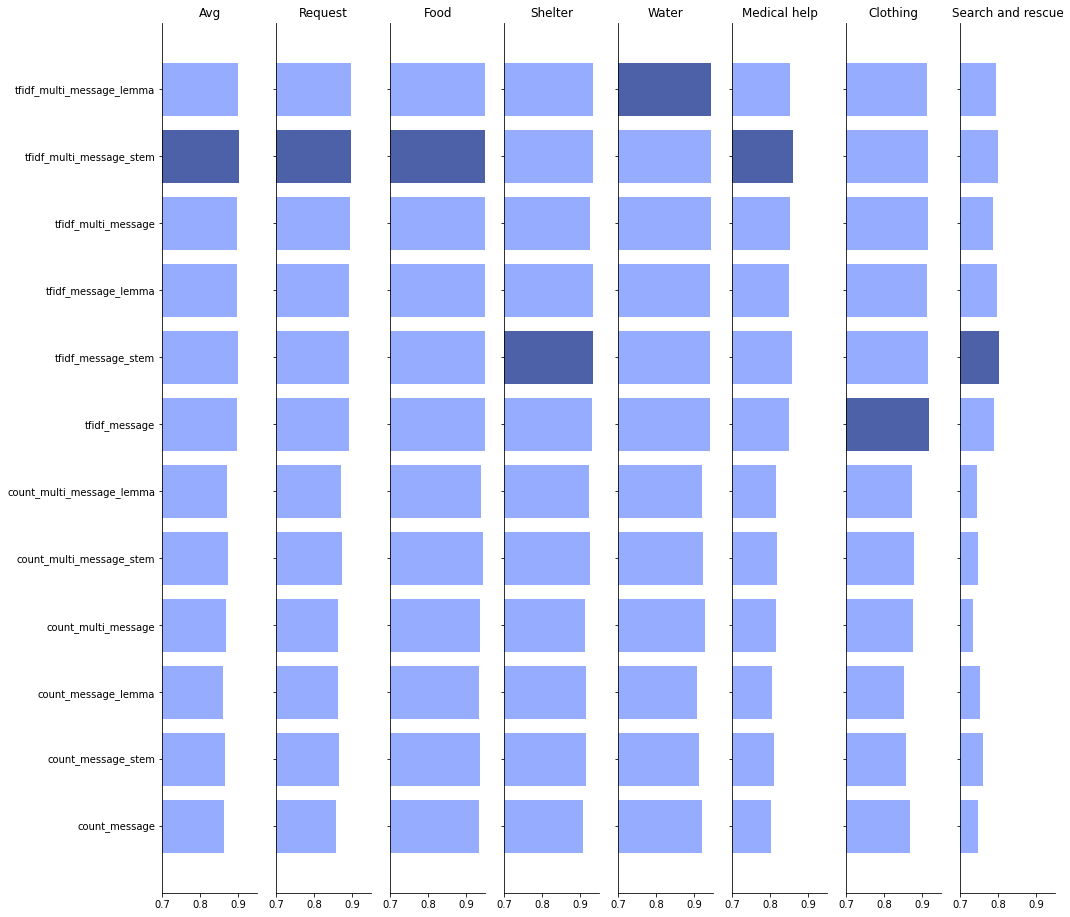

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=8, sharey="all", figsize=(16,16))
axs = axs.ravel()

for index in range(8):
    axs[index].barh(vis['key'], vis[plot_cols[index]], color=vis_melted[vis_melted["type"] == plot_cols[index]]['color'])
    axs[index].set_xlim(0.7, 0.95)
    axs[index].spines['right'].set_visible(False)
    axs[index].spines['top'].set_visible(False)
    axs[index].set_title(plot_cols[index].replace('_', ' ').capitalize())

    
plt.show()
fig.savefig('./result/plot.png')